In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import itertools

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using %s for computation" % device)

Using cuda for computation


In [3]:
project_dir = ''
images_dir = project_dir + 'images/'
model_dir = project_dir + 'models/'

In [4]:
def show_images(images):
    images = torchvision.utils.make_grid(images)
    show_image(images)


def show_image(img):
    plt.imshow(img.permute(1, 2, 0), interpolation="bicubic")
    plt.show()

In [5]:
image_size = 64
hidden_size = 1024
latent_size = 128
columns = 'Black_Hair	Blond_Hair	Brown_Hair	Male	No_Beard	Smiling	Straight_Hair	Wavy_Hair	Young'
columns = columns.split('\t')
num_columns = len(columns)

In [6]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), 1024, 1, 1)

In [35]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, image_dim=image_size, hidden_size=hidden_size, latent_size=latent_size, num_classes=num_columns):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, 4, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 4, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2),
            nn.LeakyReLU(0.2),
            Flatten(),
        )
        self.encoder_mean = nn.Linear(hidden_size, latent_size)
        self.encoder_logvar = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, latent_size - num_classes)
        self.fc4 = nn.Linear(latent_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, hidden_size - num_classes)
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(hidden_size, 128, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 5, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 6, 2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, 6, 2),
            nn.Sigmoid()
        )

    def sample(self, log_var, mean):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, x, a):
        x = self.encoder(x)
        x = self.fc1(x)
        x = torch.cat((x, a), 1)
        x = self.fc2(x)

        log_var = self.encoder_logvar(x)
        mean = self.encoder_mean(x)
        z = self.sample(log_var, mean)

        z = self.fc3(z)
        z = torch.cat((z, a), 1)
        x = self.fc4(z)
        x = self.decoder(x)

        return x, mean, log_var


vae = VAE().to(device)
vae.load_state_dict(torch.load(
    model_dir+"Conditional-VAE.pt", map_location=torch.device(device)))

<All keys matched successfully>

In [36]:
z = torch.randn(128)

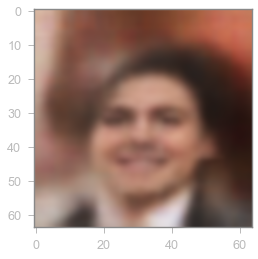

In [37]:
values = {
    'Black_Hair': 1.,
    'Blond_Hair': -1.,
    'Brown_Hair': -1.,
    'Male': 1.,
    'No_Beard': 1.,
    'Smiling': 1.,
    'Straight_Hair': -1.,
    'Wavy_Hair': 1.,
    'Young': 1.
}

label = torch.FloatTensor(list(values.values()))
vae.eval()
with torch.no_grad():
    z = z.to(device)
    label = label.to(device)
    z = vae.fc3(z)
    z = torch.cat((z, label))
    x = vae.fc4(z)
    x = x.reshape(1, -1)
    x = vae.decoder(x)
    show_images(x.cpu())
    torchvision.utils.save_image(
        x.cpu(), images_dir + 'test/29.png')

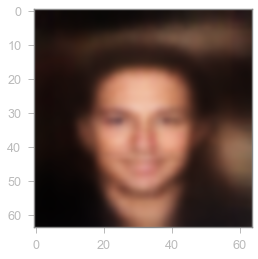

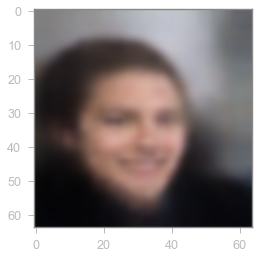

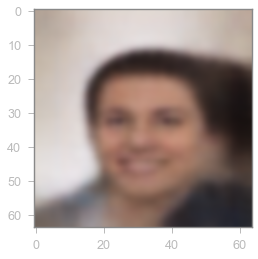

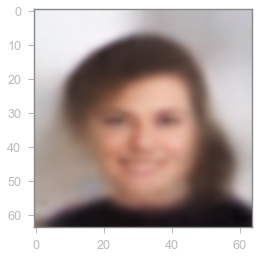

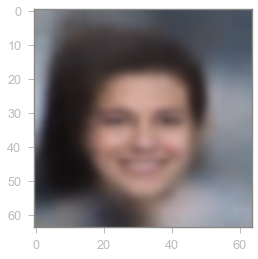

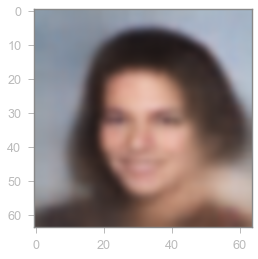

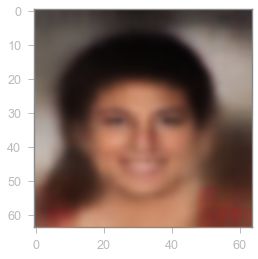

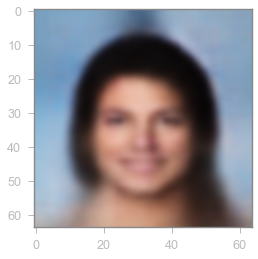

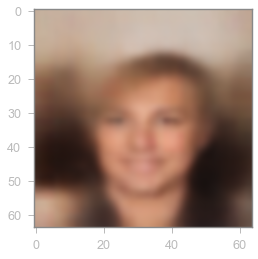

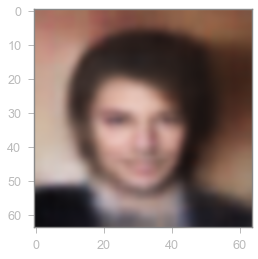

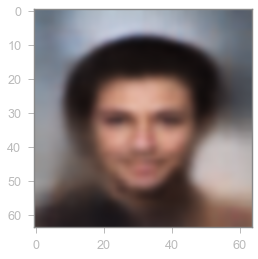

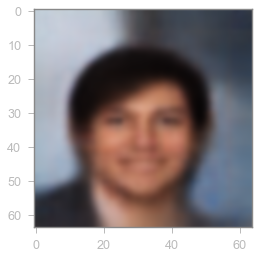

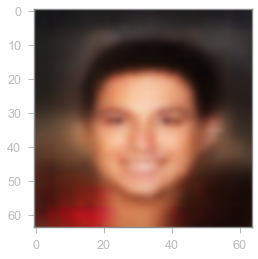

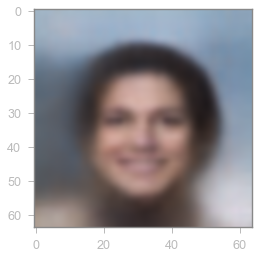

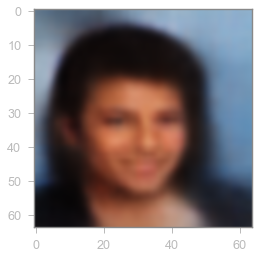

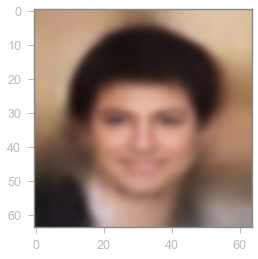

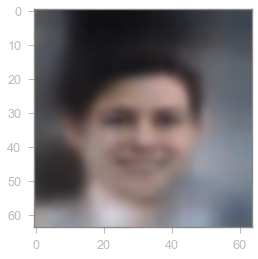

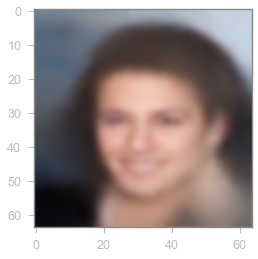

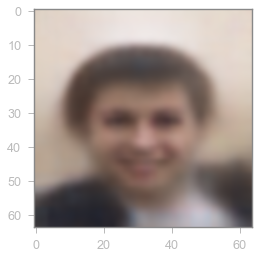

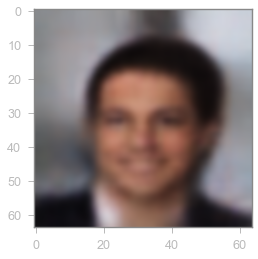

In [39]:
ran = 20
for i in range(ran):
    values = {
        'Black_Hair': 1.,
        'Blond_Hair': -1.,
        'Brown_Hair': -1.,
        'Male': 1.,
        'No_Beard': 1.,
        'Smiling': 1.,
        'Straight_Hair': -1.,
        'Wavy_Hair': 1.,
        'Young': 1.
    }

    label = torch.FloatTensor(list(values.values()))
    z = torch.randn(128)
    vae.eval()
    with torch.no_grad():
        z = z.to(device)
        label = label.to(device)
        z = vae.fc3(z)
        z = torch.cat((z, label))
        x = vae.fc4(z)
        x = x.reshape(1, -1)
        x = vae.decoder(x)
        show_images(x.cpu())
        torchvision.utils.save_image(
            x.cpu(), images_dir + 'test/' + str(i).zfill(2) + '.png')